In [ ]:
from google.colab import drive
drive.mount('/content/dinhtu')

Mounted at /content/dinhtu


# Install Detectron2 dependencies

In [ ]:
# Install dependencies -use cu101 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 67.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 276kB 7.1MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=ad85916afc22a90cc2b0966ddb534d828cf3fdea68358bf7874a1e9bf1883609
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip

In [ ]:
# install detectron2 lastest version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 788kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201204-cp36-none-any.whl size=44622 sha256=080c8fd2d5d7cb0c9d1964078b6dec6d3fcd744496e6aaa160c28f51c2a2aef1
  Stored in directory: /root/.cache/pip/wheels/b7/c9/47/dc3ce6f67e8cbfb4dec8e9ce981a2aa67b56525d7b91b510af
Successfully built fvcore


In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and register custom Detectron2 data

In [ ]:
# My registry datacoco is loaded from Drive
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coco_data_train", {}, "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/train/_annotations.coco.json", "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/train")
register_coco_instances("coco_data_val", {}, "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/valid/_annotations.coco.json", "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/valid")
register_coco_instances("coco_data_test", {}, "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/test/_annotations.coco.json", "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/test")

[12/08 17:08:42 d2.data.datasets.coco]: Loading /content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/train/_annotations.coco.json takes 52.69 seconds.
[12/08 17:08:42 d2.data.datasets.coco]: Loaded 17843 images in COCO format from /content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/train/_annotations.coco.json


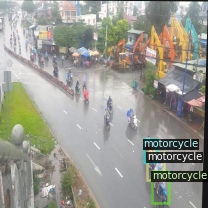

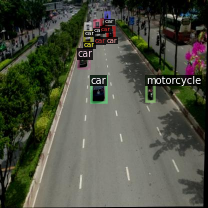

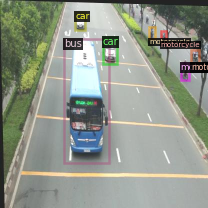

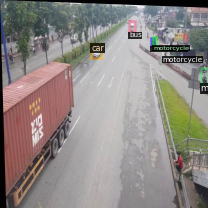

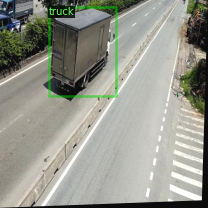

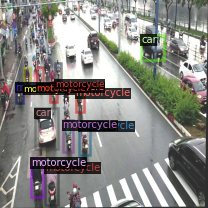

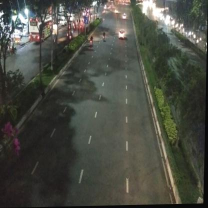

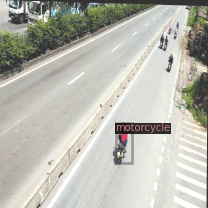

In [ ]:
# Visualize training data
my_dataset_train_metadata = MetadataCatalog.get("coco_data_train")
dataset_dicts = DatasetCatalog.get("coco_data_train")

import random
from detectron2.utils.visualizer import Visualizer

#Visualize 8 image heading with anotations  
for d in random.sample(dataset_dicts, 8):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train custom Detectron2 detector

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training.
#Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

##Faster R-CNN - R_101_DC5_3x

* Select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines



In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.config import get_cfg
import os

#Training model Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_data_train",)
cfg.DATASETS.TEST = ("coco_data_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

++
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/08 17:09:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_3e0943.pkl: 739MB [00:25, 28.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.


[12/08 17:09:39 d2.engine.train_loop]: Starting training from iteration 0
[12/08 17:10:27 d2.utils.events]:  eta: 0:58:58  iter: 19  total_loss: 2.794  loss_cls: 1.909  loss_box_reg: 0.816  loss_rpn_cls: 0.043  loss_rpn_loc: 0.016  time: 2.3633  data_time: 0.0411  lr: 0.000020  max_mem: 5797M
[12/08 17:11:14 d2.utils.events]:  eta: 0:55:49  iter: 39  total_loss: 2.536  loss_cls: 1.646  loss_box_reg: 0.876  loss_rpn_cls: 0.036  loss_rpn_loc: 0.017  time: 2.3481  data_time: 0.0090  lr: 0.000040  max_mem: 5797M
[12/08 17:12:01 d2.utils.events]:  eta: 0:55:26  iter: 59  total_loss: 2.030  loss_cls: 1.139  loss_box_reg: 0.834  loss_rpn_cls: 0.037  loss_rpn_loc: 0.015  time: 2.3619  data_time: 0.0098  lr: 0.000060  max_mem: 5797M
[12/08 17:12:50 d2.utils.events]:  eta: 0:55:22  iter: 79  total_loss: 1.747  loss_cls: 0.823  loss_box_reg: 0.851  loss_rpn_cls: 0.039  loss_rpn_loc: 0.014  time: 2.3775  data_time: 0.0086  lr: 0.000080  max_mem: 5797M
[12/08 17:13:38 d2.utils.events]:  eta: 0:55:0

## Training curves in tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

#Test evaluation

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

#Testing model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("coco_data_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "coco_data_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[12/08 18:34:57 d2.data.datasets.coco]: Loaded 850 images in COCO format from /content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/test/_annotations.coco.json
[12/08 18:34:57 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  vehicles  | 0            |    bus     | 102          |    car     | 1405         |
| container  | 119          | motorcycle | 2220         |   truck    | 337          |
|            |              |            |              |            |              |
|   total    | 4183         |            |              |            |              |
[12/08 18:34:57 d2.data.common]: Serializing 850 elements to byte tensors and concatenating them all ...
[12/08 18:34:57 d2.data.common]: Serialized dataset takes 0.36 MiB
[12/08 18:34:57 d2.evaluation.evaluator]: Start inference on 850 i

OrderedDict([('bbox',
              {'AP': 60.25742265137322,
               'AP-bus': 75.1396097334251,
               'AP-car': 62.58840544199814,
               'AP-container': 62.381022610981205,
               'AP-motorcycle': 44.55866748773133,
               'AP-truck': 56.61940798273031,
               'AP-vehicles': nan,
               'AP50': 78.3860303679184,
               'AP75': 70.73334555502171,
               'APl': 69.40365264643522,
               'APm': 66.13530718115234,
               'APs': 60.769641092311986})])

# Inference with Detectron2 saved weights on Testset



In [ ]:
%ls ./output/

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1607447348.754d2414cc37.57.0  metrics.json
instances_predictions.pth                         model_final.pth


In [ ]:
#Running saved FASTER RCNN model 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("coco_data_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("coco_data_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

#Visualizing images predicted on raw testdata
for imageName in glob.glob('/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],metadata=test_metadata, scale=0.8)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

#Save pretrained model, result metrics and label to demo

In [ ]:
with open("output/config.yaml", "w") as f:
    f.write(cfg.dump())  

In [ ]:
import json
list_classes=list((test_metadata.thing_classes))
dataset_name=str((test_metadata.name))

# Creating config file for passing metadata.
anotations_coco_demo = {}
anotations_coco_demo['number_of_class'] = len(list_classes)
anotations_coco_demo['classes_pretrained'] = list_classes
anotations_coco_demo['dataset_model_name'] = dataset_name

print(anotations_coco_demo)

# Open and read the file after the appending:
with open('/content/output/anotations_coco_demo.json', 'w+') as json_file:
  json.dump(anotations_coco_demo, json_file)          #Save label trained model 


{'number_of_class': 6, 'classes_pretrained': ['vehicles', 'bus', 'car', 'container', 'motorcycle', 'truck'], 'dataset_model_name': 'coco_data_test'}


In [ ]:
#Save pretrained model as a zip file
import shutil
shutil.make_archive('pretrained_model_r101_dc5', 'zip', '/content/output')
%cp "/content/pretrained_model_r101_dc5.zip" "/content/dinhtu/MyDrive/vehicles_detection/Tu_workspace_2"